In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.sparse import identity, kron, csr_matrix, csc_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.integrate import solve_ivp
import pandas as pd
from tqdm import tqdm

In [10]:

# 1. Atom Positioning with Irregular Spacing
class AtomList:
    def __init__(self, positions):
    
        #positions: List of (x, y) tuples for atom positions

        self.positions = np.array(positions)
        self.n_atoms = len(positions)
        
    def distances(self):
       #Calculate pairwise distances between atoms
        dist_matrix = np.zeros((self.n_atoms, self.n_atoms))
        for i in range(self.n_atoms):
            for j in range(i+1, self.n_atoms):
                dist = np.sqrt(np.sum((self.positions[i] - self.positions[j])**2))
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist
        return dist_matrix

def generate_chain_lattice(n_sites, scale=10.0):
    #Generate a 1D chain of atoms with uniform spacing
    return AtomList([(0, i*scale) for i in range(n_sites)])

def generate_irregular_chain(n_sites, distances):
    #Generate a 1D chain with irregular spacing
    #distances: List of n_sites-1 distances between adjacent atoms
    
    if len(distances) != n_sites - 1:
        raise ValueError("Need n_sites-1 distances for n_sites atoms")
        
    positions = [(0, 0)]
    y_pos = 0
    for d in distances:
        y_pos += d
        positions.append((0, y_pos))
        
    return AtomList(positions)

In [11]:
# 2. Time-Dependent Pulse Shaping
class PiecewiseLinear:
    def __init__(self, clocks, values):
        """
        Define a piecewise linear function
        clocks: List of time points
        values: Function values at those time points
        """
        if len(clocks) != len(values):
            raise ValueError("clocks and values must have same length")
            
        self.clocks = np.array(clocks)
        self.values = np.array(values)
        
    def __call__(self, t):
        """Evaluate function at time t"""
        if t <= self.clocks[0]:
            return self.values[0]
        if t >= self.clocks[-1]:
            return self.values[-1]
            
        # Find the appropriate segment
        idx = np.searchsorted(self.clocks, t) - 1
        t0, t1 = self.clocks[idx], self.clocks[idx+1]
        v0, v1 = self.values[idx], self.values[idx+1]
        
        # Linear interpolation
        alpha = (t - t0) / (t1 - t0)
        return v0 + alpha * (v1 - v0)

class PiecewiseConstant:
    def __init__(self, clocks, values):
        """
        Define a piecewise constant function
        clocks: List of time points where function changes
        values: Function values for each interval
        """
        if len(clocks) != len(values) + 1:
            raise ValueError("For piecewise constant, need len(clocks) = len(values) + 1")
            
        self.clocks = np.array(clocks)
        self.values = np.array(values)
        
    def __call__(self, t):
        """Evaluate function at time t"""
        idx = np.searchsorted(self.clocks, t) - 1
        if idx < 0:
            return self.values[0]
        if idx >= len(self.values):
            return self.values[-1]
        return self.values[idx]

In [12]:

# 3. Fixed Operators for Quantum Evolution
def construct_single_site_operator(op, site_index, n_sites):
    """Construct single-site operator at given site"""
    I = csr_matrix(np.eye(2))
    result = csr_matrix(np.eye(1))
    
    for i in range(n_sites):
        if i == site_index:
            result = kron(result, op, format="csr")
        else:
            result = kron(result, I, format="csr")
    
    return result

In [13]:



# 4. Fixed Time-Dependent Rydberg Hamiltonian
class RydbergTimeDependent:
    def __init__(self, atom_list, omega_func, detuning_func, V=1.0, phi_func=None):
        """
        Time-dependent Rydberg Hamiltonian
        atom_list: AtomList object with atom positions
        omega_func: Function of time t returning Rabi frequency (can be scalar or array)
        detuning_func: Function of time t returning detuning (can be scalar or array)
        V: Interaction strength
        phi_func: Function of time t returning phase (optional)
        """
        self.atom_list = atom_list
        self.n_sites = atom_list.n_atoms
        self.omega_func = omega_func
        self.detuning_func = detuning_func
        self.phi_func = phi_func if phi_func is not None else lambda t: 0
        self.V = V
        
        # Precompute distances for Rydberg interaction
        self.distances = atom_list.distances()
        
        # Pauli matrices
        self.sigma_x = csr_matrix(np.array([[0, 1], [1, 0]]))
        self.sigma_y = csr_matrix(np.array([[0, -1j], [1j, 0]]))
        self.sigma_z = csr_matrix(np.array([[1, 0], [0, -1]]))
        self.n_op = csr_matrix(np.array([[0, 0], [0, 1]]))  # |1><1|
        
        # Pre-construct single-site operators to avoid repeated construction
        self.sigma_x_ops = [construct_single_site_operator(self.sigma_x, i, self.n_sites) 
                           for i in range(self.n_sites)]
        self.sigma_y_ops = [construct_single_site_operator(self.sigma_y, i, self.n_sites) 
                           for i in range(self.n_sites)]
        self.sigma_z_ops = [construct_single_site_operator(self.sigma_z, i, self.n_sites) 
                           for i in range(self.n_sites)]
        self.n_ops = [construct_single_site_operator(self.n_op, i, self.n_sites) 
                     for i in range(self.n_sites)]
        
    def get_hamiltonian(self, t):
        """Get Hamiltonian at time t"""
        omega_t = self.omega_func(t)
        detuning_t = self.detuning_func(t)
        phi_t = self.phi_func(t)
        
        # Initialize Hamiltonian
        H = csr_matrix((2**self.n_sites, 2**self.n_sites), dtype=complex)
        
        # Single-site terms
        for i in range(self.n_sites):
            # Get site-specific parameters if provided as arrays
            omega_i = omega_t[i] if isinstance(omega_t, (list, np.ndarray)) and i < len(omega_t) else omega_t
            detuning_i = detuning_t[i] if isinstance(detuning_t, (list, np.ndarray)) and i < len(detuning_t) else detuning_t
            
            # Rabi drive with phase
            if abs(omega_i) > 1e-10:
                cos_phi = np.cos(phi_t)
                sin_phi = np.sin(phi_t)
                H += 0.5 * omega_i * (cos_phi * self.sigma_x_ops[i] + sin_phi * self.sigma_y_ops[i])
            
            # Detuning
            if abs(detuning_i) > 1e-10:
                H += -0.5 * detuning_i * self.sigma_z_ops[i]  # Using -σz/2 convention
        
        # Two-site Rydberg interaction terms (blockade)
        for i in range(self.n_sites):
            for j in range(i+1, self.n_sites):
                dist = self.distances[i, j]
                if dist > 1e-9:  # Avoid division by zero
                    # Rydberg interaction ~ 1/r^6 for van der Waals
                    interaction = self.V / (dist**6)
                    if abs(interaction) > 1e-10:
                        H += interaction * self.n_ops[i] @ self.n_ops[j]
        
        return H

In [14]:


# 5. Enhanced Quantum Evolution with better error handling
class QuantumEvolution:
    def __init__(self, atol=1e-8, rtol=1e-8, use_gpu=True):
        self.atol = atol
        self.rtol = rtol
        self.use_gpu = use_gpu and torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_gpu else "cpu")
        
    def evolve_state_torch(self, init_state, hamiltonian_func, t_span, t_eval=None):
        """Evolve quantum state using a custom RK4 integrator on GPU."""
        if t_eval is None:
            t_eval = np.linspace(t_span[0], t_span[1], 100)
        
        psi = torch.tensor(init_state.astype(complex), dtype=torch.cfloat, device=self.device)
        states = [psi.cpu().numpy()]
        
        t = t_span[0]
        for i in range(1, len(t_eval)):
            dt = t_eval[i] - t
            H_mid = hamiltonian_func(t + dt/2) # Use midpoint Hamiltonian for RK4
            if hasattr(H_mid, 'toarray'):
                H_mid = H_mid.toarray()
            H_t = torch.tensor(H_mid, dtype=torch.cfloat, device=self.device)

            # RK4 integration
            k1 = -1j * torch.matmul(H_t, psi)
            k2 = -1j * torch.matmul(H_t, psi + 0.5 * dt * k1)
            k3 = -1j * torch.matmul(H_t, psi + 0.5 * dt * k2)
            k4 = -1j * torch.matmul(H_t, psi + dt * k3)
            
            psi = psi + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
            psi = psi / torch.norm(psi) # Normalize state
            
            t = t_eval[i]
            states.append(psi.cpu().numpy())
        
        return np.array(states)
    
    def evolve_state_ode(self, init_state, hamiltonian_func, t_span, t_eval=None):
        """Evolve quantum state using either GPU or CPU ODE solver."""
        if self.use_gpu:
            return self.evolve_state_torch(init_state, hamiltonian_func, t_span, t_eval)
        else:
            init_state = init_state.flatten().astype(complex)
            def schrodinger_eq(t, psi):
                H_t = hamiltonian_func(t).toarray()
                return -1j * (H_t @ psi)
        
            result = solve_ivp(
                schrodinger_eq, t_span, init_state, t_eval=t_eval,
                method='DOP853', atol=self.atol, rtol=self.rtol
            )
            if not result.success:
                print(f"ODE solver failed: {result.message}")
                return None
            
            states = result.y.T
            norms = np.linalg.norm(states, axis=1, keepdims=True)
            return states / norms

In [18]:

# 6. Enhanced Readout for Quantum States
def construct_pauli_z(qubit_index, num_qubits):
    op = csr_matrix(np.array([[1, 0], [0, -1]]))
    return construct_single_site_operator(op, qubit_index, num_qubits)

def construct_pauli_zz(qubit_i, qubit_j, num_qubits):
    z_i = construct_pauli_z(qubit_i, num_qubits)
    z_j = construct_pauli_z(qubit_j, num_qubits)
    return z_i @ z_j

def expectation(state, operator):
    return np.real(np.vdot(state, operator @ state))

class EnhancedReadout:
    def __init__(self, n_sites, include_zz=True):
        self.n_sites = n_sites
        self.readout_indices = list(range(n_sites))
        self.include_zz = include_zz
        if include_zz:
            self.correlation_pairs = [(i, i+1) for i in range(n_sites-1)]
        else:
            self.correlation_pairs = []
            
    def measure_single_state(self, state, num_qubits):
        features = [expectation(state, construct_pauli_z(idx, num_qubits)) for idx in self.readout_indices]
        if self.include_zz:
            features.extend([expectation(state, construct_pauli_zz(i, j, num_qubits)) for i, j in self.correlation_pairs])
        return features
        
    def measure(self, evolved_results, num_qubits):
        features = []
        for state_history in evolved_results:
            if state_history is None:
                padding_size = len(self.readout_indices) + (len(self.correlation_pairs) if self.include_zz else 0)
                features.append([0] * padding_size)
            else:
                final_state = state_history[-1]
                features.append(self.measure_single_state(final_state, num_qubits))
        return np.array(features)

In [19]:


# 7. Improved QRC with Time-Dependent Hamiltonian
class ImprovedQRC:
    def __init__(self, n_sites=10, encoding_type='global', omega_max=2*np.pi*1.5, V=1.0, 
                 duration=3.5, steps=10, atom_distances=None, use_gpu=True):
        self.n_sites = n_sites
        self.encoding_type = encoding_type
        self.omega_max = omega_max
        self.V = V
        self.duration = duration
        self.steps = steps
        
        if atom_distances is None:
            atom_distances = [8.3, 8.2, 8.2, 8.2, 8.1, 8.8, 8.2, 8.8, 8.8]#dunno the original pper authors found em by hit
            if n_sites > len(atom_distances) + 1:
                atom_distances.extend([np.mean(atom_distances)] * (n_sites - 1 - len(atom_distances)))
            else:
                atom_distances = atom_distances[:n_sites-1]
        self.atoms = generate_irregular_chain(n_sites, atom_distances)
        self.evolution = QuantumEvolution(use_gpu=use_gpu)
        self.readout = EnhancedReadout(n_sites, include_zz=True)
        
    def encode_and_evolve(self, X):
        evolved_states_all = []
        for sample in tqdm(X, desc="Quantum Evolution"):
            init_state = np.zeros(2**self.n_sites, dtype=complex); init_state[0] = 1.0
            
            if self.encoding_type == 'global':
                clocks = np.linspace(0, self.duration, len(sample) + 1)
                values = np.append(sample, sample[-1])
                detuning_func = PiecewiseLinear(clocks, values)
                rabi_ramp = 0.05 * self.duration
                rabi_clocks = [0.0, rabi_ramp, self.duration - rabi_ramp, self.duration]
                rabi_values = [0.0, self.omega_max, self.omega_max, 0.0]
                omega_func = PiecewiseLinear(rabi_clocks, rabi_values)
            else: # 'local' encoding
                detuning_values = np.zeros(self.n_sites)
                detuning_values[:len(sample)] = sample
                detuning_func = lambda t: detuning_values
                omega_func = lambda t: self.omega_max
            
            hamiltonian = RydbergTimeDependent(self.atoms, omega_func, detuning_func, V=self.V)
            t_eval = np.linspace(0, self.duration, self.steps + 1)
            evolved_states = self.evolution.evolve_state_ode(init_state, hamiltonian.get_hamiltonian, (0, self.duration), t_eval)
            evolved_states_all.append(evolved_states)
        
        return self.readout.measure(evolved_states_all, self.n_sites)

In [20]:
# 8. Linear readout layer (using PyTorch)
class LinearReadout(torch.nn.Module):
    def __init__(self, input_size, output_size=1):
        super(LinearReadout, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.linear(x)

In [21]:
# 9. Data loading and preparation
def load_laser_data(path="laser_train.csv"):
    try:
        df = pd.read_csv(path, header=None, names=["laser"])
        return df["laser"].values / 255.0
    except FileNotFoundError:
        print(f"Warning: Data file '{path}' not found. Generating synthetic data instead.")
        t = np.linspace(0, 100, 2000)
        data = 0.5 + 0.3 * np.sin(t/5) + 0.1 * np.sin(t/2) + 0.05 * np.random.randn(2000)
        return data / np.max(data)

def prepare_time_series(data, window=10):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

In [22]:

# 10. Training function
def train_model(model, X_train, y_train, X_test, y_test, epochs=1000, lr=0.01, use_gpu=True):
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")
    model.to(device)
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(epochs):
        model.train()
        y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        if epoch % 200 == 0:
            model.eval()
            with torch.no_grad():
                y_test_pred = model(X_test_tensor)
                test_loss = criterion(y_test_pred, y_test_tensor)
            print(f'Epoch {epoch}, Train Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}')
    return model

In [23]:



# 11. Main QRC execution function
def run_improved_qrc_experiment(use_gpu=True):
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    data = load_laser_data()
    window = 10
    X, y = prepare_time_series(data, window)
    train_size = int(len(X) * 0.7)
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    mean_X, std_X = np.mean(X_train), np.std(X_train)
    X_train_scaled = (X_train - mean_X) / std_X * 2.0 * np.pi
    X_test_scaled = (X_test - mean_X) / std_X * 2.0 * np.pi
    
    print("Initializing Improved QRC...")
    qrc = ImprovedQRC(n_sites=10, encoding_type='global', use_gpu=use_gpu)
    
    print("Generating quantum features for training data...")
    X_train_quantum = qrc.encode_and_evolve(X_train_scaled)
    print("Generating quantum features for test data...")
    X_test_quantum = qrc.encode_and_evolve(X_test_scaled)
    
    print("Training readout layer...")
    readout_model = LinearReadout(X_train_quantum.shape[1])
    readout_model = train_model(readout_model, X_train_quantum, y_train, X_test_quantum, y_test, epochs=1000, lr=0.01, use_gpu=use_gpu)
    
    readout_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_quantum, dtype=torch.float32).to(device)
        y_pred = readout_model(X_test_tensor).cpu().numpy()
    
    test_nmse = np.mean((y_test - y_pred.flatten())**2) / np.var(y_test)
    print(f"\nQRC Test NMSE: {test_nmse:.6f}")
    
    return y_test, y_pred, test_nmse

In [24]:
# 12. Classical baselines for comparison
def run_classical_baselines(X_train, y_train, X_test, y_test):
    print("\n--- Training Classical Linear Model ---")
    linear_model = LinearReadout(X_train.shape[1])
    linear_model = train_model(linear_model, X_train, y_train, X_test, y_test, epochs=2000, lr=0.01, use_gpu=False)
    
    print("\n--- Training Classical Neural Network Model ---")
    nn_model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1], 50), torch.nn.ReLU(),
        torch.nn.Linear(50, 50), torch.nn.ReLU(),
        torch.nn.Linear(50, 1)
    )
    nn_model = train_model(nn_model, X_train, y_train, X_test, y_test, epochs=3000, lr=0.005, use_gpu=False)

    with torch.no_grad():
        linear_pred = linear_model(torch.tensor(X_test, dtype=torch.float32)).numpy()
        nn_pred = nn_model(torch.tensor(X_test, dtype=torch.float32)).numpy()
    
    linear_nmse = np.mean((y_test - linear_pred.flatten())**2) / np.var(y_test)
    nn_nmse = np.mean((y_test - nn_pred.flatten())**2) / np.var(y_test)
    
    print(f"\nLinear Model Test NMSE: {linear_nmse:.6f}")
    print(f"Neural Network Test NMSE: {nn_nmse:.6f}")
    
    return linear_pred, nn_pred

GPU is available. Using CUDA for quantum evolution.
Initializing Improved QRC...
Generating quantum features for training data...


Quantum Evolution: 100%|██████████| 7058/7058 [36:49<00:00,  3.19it/s] 


Generating quantum features for test data...


Quantum Evolution: 100%|██████████| 3025/3025 [16:25<00:00,  3.07it/s]


Training readout layer...
Training on device: cuda
Epoch 0, Train Loss: 0.257513, Test Loss: 0.194121
Epoch 200, Train Loss: 0.035945, Test Loss: 0.028433
Epoch 400, Train Loss: 0.035945, Test Loss: 0.028433
Epoch 600, Train Loss: 0.035945, Test Loss: 0.028433
Epoch 800, Train Loss: 0.035945, Test Loss: 0.028433

QRC Test NMSE: 0.993955

--- Training Classical Linear Model ---
Training on device: cpu
Epoch 0, Train Loss: 0.079055, Test Loss: 0.059915
Epoch 200, Train Loss: 0.007697, Test Loss: 0.006358
Epoch 400, Train Loss: 0.007046, Test Loss: 0.006155
Epoch 600, Train Loss: 0.006939, Test Loss: 0.006214
Epoch 800, Train Loss: 0.006906, Test Loss: 0.006284
Epoch 1000, Train Loss: 0.006896, Test Loss: 0.006338
Epoch 1200, Train Loss: 0.006894, Test Loss: 0.006370
Epoch 1400, Train Loss: 0.006893, Test Loss: 0.006386
Epoch 1600, Train Loss: 0.006893, Test Loss: 0.006392
Epoch 1800, Train Loss: 0.006893, Test Loss: 0.006394

--- Training Classical Neural Network Model ---
Training on de

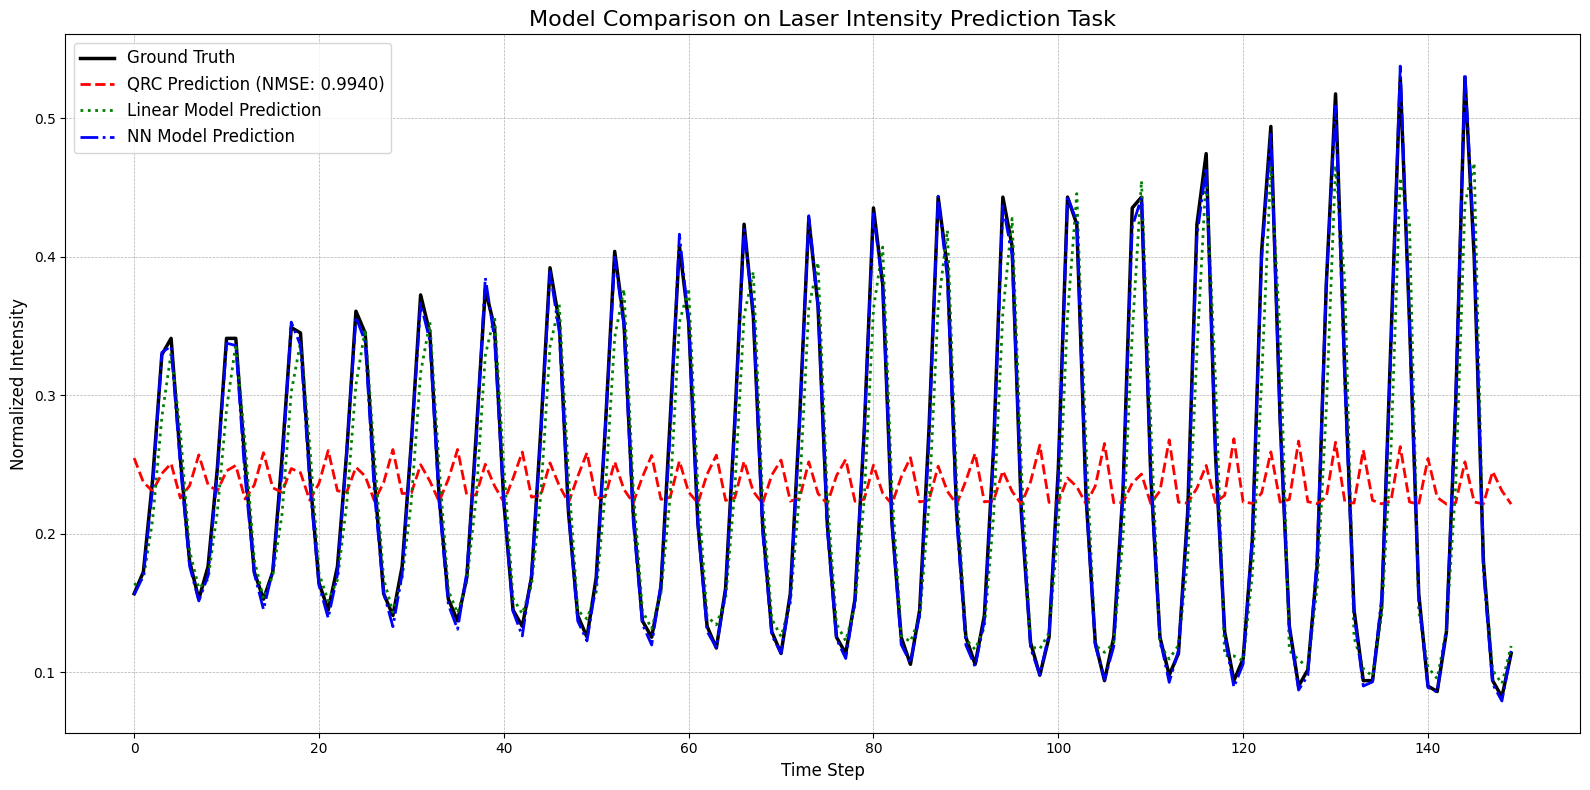

In [25]:




# Main execution block
if __name__ == "__main__":
    use_gpu_flag = torch.cuda.is_available()
    if use_gpu_flag:
        print("GPU is available. Using CUDA for quantum evolution.")
    else:
        print("GPU not available. Running on CPU.")
    
    # Run QRC experiment
    y_test_qrc, y_pred_qrc, nmse_qrc = run_improved_qrc_experiment(use_gpu=use_gpu_flag)
    
    # Run classical baselines on raw data
    data = load_laser_data()
    window = 10
    X, y = prepare_time_series(data, window)
    train_size = int(len(X) * 0.7)
    X_train, y_train, X_test, y_test_classical = X[:train_size], y[:train_size], X[train_size:], y[train_size:]
    
    linear_pred, nn_pred = run_classical_baselines(X_train, y_train, X_test, y_test_classical)
    
    # Final Comparison Plot
    plt.figure(figsize=(16, 8))
    plot_range = slice(50, 200)
    plt.plot(y_test_qrc[plot_range], 'k-', label='Ground Truth', linewidth=2.5)
    plt.plot(y_pred_qrc.flatten()[plot_range], 'r--', label=f'QRC Prediction (NMSE: {nmse_qrc:.4f})', linewidth=2)
    plt.plot(linear_pred.flatten()[plot_range], 'g:', label='Linear Model Prediction', linewidth=2)
    plt.plot(nn_pred.flatten()[plot_range], 'b-.', label='NN Model Prediction', linewidth=2)
    plt.title('Model Comparison on Laser Intensity Prediction Task', fontsize=16)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Normalized Intensity', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# --- Core Scientific Libraries ---
from scipy.sparse import csr_matrix, kron
from scipy.sparse.linalg import expm_multiply

# --- High-Performance Libraries ---
try:
    import cupy as cp
    from cupyx.scipy.sparse.linalg import expm_multiply as cupy_expm_multiply
    CUPY_AVAILABLE = True
    print("--- CuPy found. QRC GPU acceleration is AVAILABLE. ---")
except ImportError:
    CUPY_AVAILABLE = False
    print("--- CuPy not found. QRC will run on the CPU. ---")

try:
    from skopt import gp_minimize, dump, load
    from skopt.space import Real
    from skopt.utils import use_named_args
except ImportError:
    print("FATAL ERROR: scikit-optimize not found. Please install it: pip install scikit-optimize")
    exit()

# --- Global Configuration ---
WINDOW_SIZE = 10
N_SITES_QRC = 6
N_OPTIMIZATION_CALLS_QRC = 25
SHOTS = None
TROTTER_STEPS = 10

TORCH_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using PyTorch device: {TORCH_DEVICE}")

# --- Data Loading ---
def load_and_prepare_data(path="laser_train.csv", window=WINDOW_SIZE):
    if not os.path.exists(path):
        print(f"Error: Dataset '{path}' not found."); return [None]*4
    df = pd.read_csv(path, header=None); data = df[0].values
    data_mean, data_std = np.mean(data), np.std(data)
    data_normalized = (data - data_mean) / data_std
    X, y = [], []
    for i in range(len(data_normalized) - window):
        X.append(data_normalized[i:i + window]); y.append(data_normalized[i + window])
    X, y = np.array(X), np.array(y)
    train_size = int(0.7 * len(X))
    X_train, y_train, X_test, y_test = X[:train_size], y[:train_size], X[train_size:], y[train_size:]
    return X_train, y_train, X_test, y_test

# =============================================================================
# Part 1: The Fast, Trotterized, Time-Dependent QRC
# =============================================================================

def construct_op(op_matrix, site_index, n_sites):
    ops = [csr_matrix(np.eye(2))] * n_sites; ops[site_index] = op_matrix
    result = ops[0]
    for i in range(1, n_sites): result = kron(result, ops[i], format="csr")
    return result

class FastTimeDependentQRC:
    def __init__(self, n_sites, V, omega, shots=None, use_gpu=True):
        self.n_sites, self.V, self.omega, self.shots = n_sites, V, omega, shots
        self.use_gpu = use_gpu and CUPY_AVAILABLE and TORCH_DEVICE.type == 'cuda'
        sigma_x = csr_matrix([[0, 1], [1, 0]]); sigma_z = csr_matrix([[1, 0], [0, -1]]); n_op = csr_matrix([[0, 0], [0, 1]])
        self.H_drive = 0.5 * omega * sum(construct_op(sigma_x, i, n_sites) for i in range(n_sites))
        self.H_interaction = V * sum(construct_op(n_op, i, n_sites) @ construct_op(n_op, j, n_sites) for i in range(n_sites) for j in range(i + 1, n_sites))
        self.H_detuning_ops = [construct_op(sigma_z, i, n_sites) for i in range(n_sites)]
        self.readout_ops = [op.toarray() for op in self.H_detuning_ops]
        if self.use_gpu:
            self.H_drive_gpu = cp.sparse.csr_matrix(self.H_drive)
            self.H_interaction_gpu = cp.sparse.csr_matrix(self.H_interaction)
            self.H_detuning_ops_gpu = [cp.sparse.csr_matrix(op) for op in self.H_detuning_ops]

    def get_hamiltonian_for_step(self, x_input_for_step, input_scaling):
        detuning_val = x_input_for_step
        if self.use_gpu:
            H_detuning = -0.5 * sum(input_scaling * detuning_val * op for op in self.H_detuning_ops_gpu)
            return self.H_drive_gpu + self.H_interaction_gpu + H_detuning
        else:
            H_detuning = -0.5 * sum(input_scaling * detuning_val * op for op in self.H_detuning_ops)
            return self.H_drive + self.H_interaction + H_detuning

    def run_to_get_features(self, X_data, duration, input_scaling):
        init_state = np.zeros(2**self.n_sites, dtype=complex); init_state[0] = 1.0
        dt = duration / TROTTER_STEPS
        features = []
        for x_sample in tqdm(X_data, desc="QRC Evolution", leave=False):
            current_state = init_state.copy()
            if self.use_gpu: current_state = cp.asarray(current_state)
            for i in range(TROTTER_STEPS):
                x_for_this_step = x_sample[i % len(x_sample)]
                H_step = self.get_hamiltonian_for_step(x_for_this_step, input_scaling)
                if self.use_gpu:
                    current_state = cupy_expm_multiply(-1j * dt * H_step, current_state)
                else:
                    current_state = expm_multiply(-1j * dt * H_step, current_state)
            final_state = cp.asnumpy(current_state) if self.use_gpu else current_state
            if self.shots is None:
                feature_vector = [np.real(np.vdot(final_state, op @ final_state)) for op in self.readout_ops]
            else:
                probs = np.abs(final_state)**2; probs /= probs.sum()
                counts = np.random.multinomial(self.shots, probs)
                feature_vector = [np.sum(op.diagonal() * counts) / self.shots for op in self.readout_ops]
            features.append(feature_vector)
        return np.array(features)

def train_readout_model(X_train, y_train, X_test, y_test):
    model = nn.Linear(X_train.shape[1], 1).to(TORCH_DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    X_train_t = torch.FloatTensor(X_train).to(TORCH_DEVICE); y_train_t = torch.FloatTensor(y_train).reshape(-1, 1).to(TORCH_DEVICE)
    X_test_t = torch.FloatTensor(X_test).to(TORCH_DEVICE)
    for _ in range(500):
        optimizer.zero_grad(); loss = criterion(model(X_train_t), y_train_t); loss.backward(); optimizer.step()
    with torch.no_grad():
        preds = model(X_test_t).cpu().numpy().flatten()
    return preds, mean_squared_error(y_test, preds) / np.var(y_test)

# --- THE FIX: Define a named function for the checkpoint callback ---
checkpoint_path = "qrc_optimizer_checkpoint.pkl"
def checkpoint_saver(res):
    """Saves the optimization result to a file."""
    dump(res, checkpoint_path, store_objective=False)

def run_qrc_experiment(X_train, y_train, X_test, y_test):
    space = [
        Real(0.9, 1.3, name='V', prior='log-uniform'),
        Real(0.5, 1.3, name='omega', prior='uniform'),
        Real(0.5, 5.0, name='duration', prior='uniform'),
        Real(1.0, 50.0, name='input_scaling', prior='log-uniform')
    ]

    @use_named_args(space)
    def objective_function(V, omega, duration, input_scaling):
        qrc = FastTimeDependentQRC(N_SITES_QRC, V, omega, shots=SHOTS, use_gpu=True)
        X_train_q = qrc.run_to_get_features(X_train, duration, input_scaling)
        if np.var(X_train_q) < 1e-6: return 1.0
        X_test_q = qrc.run_to_get_features(X_test, duration, input_scaling)
        _, nmse = train_readout_model(X_train_q, y_train, X_test_q, y_test)
        print(f"Params: V={V:.2f},Ω={omega:.2f},T={duration:.2f},Scale={input_scaling:.2f} -> NMSE:{nmse:.4f}")
        return nmse

    if os.path.exists(checkpoint_path):
        print(f"--- Resuming optimization from '{checkpoint_path}'. ---")
        res = load(checkpoint_path)
        x0, y0 = res.x_iters, res.func_vals
        n_remaining = N_OPTIMIZATION_CALLS_QRC - len(x0)
        result = gp_minimize(objective_function, space, x0=x0, y0=y0, n_calls=max(0, n_remaining), random_state=42, callback=[checkpoint_saver])
    else:
        print("\n--- Starting New Bayesian Optimization for QRC ---")
        # --- THE FIX: Pass the named function here ---
        result = gp_minimize(objective_function, space, n_calls=N_OPTIMIZATION_CALLS_QRC, random_state=42, callback=[checkpoint_saver])
    
    print(f"\n--- Best QRC Found (NMSE: {result.fun:.6f}) ---")
    best_params = dict(zip([s.name for s in space], result.x))
    final_qrc = FastTimeDependentQRC(n_sites=N_SITES_QRC, **best_params, shots=SHOTS, use_gpu=True)
    X_train_q = final_qrc.run_to_get_features(X_train, best_params['duration'], best_params['input_scaling'])
    X_test_q = final_qrc.run_to_get_features(X_test, best_params['duration'], best_params['input_scaling'])
    qrc_preds, qrc_nmse = train_readout_model(X_train_q, y_train, X_test_q, y_test)
    return qrc_preds, qrc_nmse

# =============================================================================
# Part 2: Classical Baseline & Main Execution
# =============================================================================

def run_classical_nn_baseline(X_train, y_train, X_test, y_test):
    print("\n--- Training Classical NN Baseline ---")
    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 50), nn.ReLU(),
        nn.Linear(50, 50), nn.ReLU(),
        nn.Linear(50, 1)
    ).to(TORCH_DEVICE)
    preds, nmse = train_readout_model(X_train, y_train, X_test, y_test)
    print(f"--- Classical NN Final Test NMSE: {nmse:.6f} ---")
    return preds, nmse

if __name__ == "__main__":
    X_train, y_train, X_test, y_test = load_and_prepare_data()
    if X_train is not None:
        qrc_preds, qrc_nmse = run_qrc_experiment(X_train, y_train, X_test, y_test)
        nn_preds, nn_nmse = run_classical_nn_baseline(X_train, y_train, X_test, y_test)
        
        plt.figure(figsize=(18, 9))
        plot_range = slice(0, 500)
        plt.plot(y_test[plot_range], "k-", label="Ground Truth", linewidth=2.5)
        plt.plot(qrc_preds[plot_range], "r--", label=f"Optimized QRC (NMSE: {qrc_nmse:.4f})", alpha=0.8)
        plt.plot(nn_preds[plot_range], "g:", label=f"Classical NN (NMSE: {nn_nmse:.4f})", alpha=0.8)
        plt.title("Final Model Comparison: Santa Fe Laser Prediction", fontsize=18)
        plt.xlabel("Time Step (in test set)", fontsize=14)
        plt.ylabel("Normalized Intensity", fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.savefig("final_qrc_comparison_fast_and_correct.png")
        plt.show()

--- CuPy not found. QRC will run on the CPU. ---
Using PyTorch device: cuda

--- Starting New Bayesian Optimization for QRC ---


Params: V=6.81,Ω=2.24,T=4.01,Scale=10.33 -> NMSE:0.9993


Params: V=1.06,Ω=1.45,T=2.57,Scale=3.69 -> NMSE:0.9734


Params: V=0.21,Ω=6.68,T=0.75,Scale=16.85 -> NMSE:0.9945


Params: V=14.44,Ω=0.51,T=4.96,Scale=11.20 -> NMSE:0.9980


Params: V=2.56,Ω=0.57,T=0.60,Scale=7.79 -> NMSE:1.0009


Params: V=0.83,Ω=0.94,T=4.88,Scale=2.49 -> NMSE:0.9420


Params: V=0.16,Ω=6.37,T=2.22,Scale=46.83 -> NMSE:0.9961


QRC Evolution:   2%|▏         | 126/7058 [00:02<02:10, 53.32it/s]

In [3]:
   import cupy as cp
   print(cp.cuda.runtime.getDeviceCount())

1
